# Plot the calibrated model with the experimental data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
from jnk3_no_ask1 import model
import numpy as np
import matplotlib.pyplot as plt
from pysb.simulator import ScipyOdeSimulator
import pandas as pd
from equilibration_function import pre_equilibration

In [3]:
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

In [4]:
# Loading fitted parameters
param_values = np.array([p.value for p in model.parameters])
# idx_pars_calibrate = [1, 5, 9, 11, 15, 17, 23, 25, 27, 31, 35, 36, 37, 38, 39, 41, 43] #pydream
# idx_pars_calibrate = [5, 9, 11, 15, 17, 23, 25, 27, 31, 35, 36, 37, 38, 39, 41, 43] #pydream2
idx_pars_calibrate = [1, 5, 9, 11, 15, 17, 19, 23, 25, 27, 31, 35, 36, 37, 38, 39, 41, 43] #pydream3
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

fitted_pars = np.load('most_likely_par_500000_4box.npy')
# param_values[rates_of_interest_mask] = 10 ** fitted_pars

exp_data = pd.read_csv('data/exp_data_3min.csv')

# Index of Initial conditions of Arrestin
arrestin_idx = [44]
jnk3_initial_value = 0.6  # total jnk3
jnk3_initial_idxs = [47, 48, 49]
kcat_idx = [36, 37]

tspan = np.linspace(0, exp_data['Time (secs)'].values[-1], 121)
t_exp_mask = [idx in exp_data['Time (secs)'].values[:] for idx in tspan]
solver = ScipyOdeSimulator(model, tspan=tspan)

In [5]:
def display_sim_data(position):
    Y = np.copy(position)
    param_values[rates_of_interest_mask] = 10 ** Y

    pars1 = np.copy(param_values)
    pars2 = np.copy(param_values)

    # Pre-equilibration
    time_eq = np.linspace(0, 100, 100)
    pars_eq1 = np.copy(param_values)
    pars_eq2 = np.copy(param_values)

    pars_eq2[arrestin_idx] = 0
    # pars_eq2[jnk3_initial_idxs] = [0.5958, 0, 0.0042]

    all_pars = np.stack((pars_eq1, pars_eq2))
    all_pars[:, kcat_idx] = 0  # Setting catalytic reactions to zero for pre-equilibration
    eq_conc = pre_equilibration(solver, time_eq, all_pars)[1]

    # Simulating models with initials from pre-equilibration and parameters for condition with/without arrestin
    pars2[arrestin_idx] = 0
    # pars2[jnk3_initial_idxs] = [0.5958, 0, 0.0042]
    sim = solver.run(param_values=[pars1, pars2], initials=eq_conc).all

    colors = ['#000000', '#E69F00', '#CC79A7', '#009E73', '#0072B2', '#D55E00']
    marker_a = 'v'
    marker_na = 'v'

    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    ax1.plot(tspan, sim[0]['pTyr_jnk3'] / jnk3_initial_value, color=colors[3], label='p(Tyr)JNK3 sim')
    ax1.errorbar(exp_data['Time (secs)'].values, exp_data['pTyr_arrestin_avg'].values,
                 exp_data['pTyr_arrestin_std'].values,
                 linestyle='None', marker=marker_a, capsize=5, color=colors[3], label='p(Tyr)JNK3 exp')
    ax1.plot(tspan, sim[0]['pThr_jnk3'] / jnk3_initial_value, color=colors[4], label='p(Thr)JNK3 sim')
    ax1.errorbar(exp_data['Time (secs)'].values, exp_data['pThr_arrestin_avg'].values,
                 exp_data['pThr_arrestin_std'].values,
                 linestyle='None', marker=marker_a, capsize=5, color=colors[4], label='New p(Thr)JNK3 exp')
    ax1.plot(tspan, sim[0]['all_jnk3'] / jnk3_initial_value, color=colors[5], label='ppJNK3 sim')
    ax1.errorbar(exp_data['Time (secs)'].values, exp_data['ppjnk3_arrestin_avg'].values,
                 exp_data['ppjnk3_arrestin_std'].values,
                 linestyle='None', marker=marker_a, capsize=5, color=colors[5], label='ppJNK3 exp')

    ax2.plot(tspan, sim[1]['pTyr_jnk3'] / jnk3_initial_value, color=colors[3], label='p(Tyr)JNK3 -Arr sim')
    ax2.errorbar(exp_data['Time (secs)'].values, exp_data['pTyr_noarrestin_avg'].values,
                 exp_data['pTyr_noarrestin_std'].values,
                 linestyle='None', marker=marker_na, capsize=5, color=colors[3], label='p(Tyr)JNK3 -Arr exp')
    ax2.plot(tspan, sim[1]['pThr_jnk3'] / jnk3_initial_value, color=colors[4], label='p(Thr)JNK3 -Arr sim')
    ax2.errorbar(exp_data['Time (secs)'].values, exp_data['pThr_noarrestin_avg'].values,
                 exp_data['pThr_noarrestin_std'].values,
                 linestyle='None', marker=marker_na, capsize=5, color=colors[4], label='p(Thr)JNK3 -Arr exp')
    ax2.plot(tspan, sim[1]['all_jnk3'] / jnk3_initial_value, color=colors[5], label='ppJNK3 -Arr sim')
    ax2.errorbar(exp_data['Time (secs)'].values, exp_data['ppjnk3_noarrestin_avg'].values,
                 exp_data['ppjnk3_noarrestin_std'].values,
                 linestyle='None', marker=marker_na, capsize=5, color=colors[5], label='ppJNK3 -Arr exp')

    #### Code to plot old calibration ####
    # pars_old = np.load('most_likely_par_100000_3.npy')
    # param_values[rates_of_interest_mask] = 10 ** pars_old
    # param_values[jnk3_initial_idxs] = [0.43398, 0.162, 0.00402]
    # pars_eq_old = np.copy(param_values)
    # pars_eq_old[kcat_idx] = 0
    # eq_conc_old = pre_equilibration(model, time_eq, pars_eq_old)[1]
    # sim_old = solver.run(param_values=param_values, initials=eq_conc_old).all
    #
    # old_thr_avg = [0.271008408, 0.389166612, 1, 1, 1, 1, 1, 1, 1]
    # old_thr_std = [0.137960707, 0.091614886, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    # ax1.errorbar(exp_data['Time (secs)'].values, old_thr_avg, old_thr_std,
    #              linestyle='None', marker=marker_a, capsize=5, color='gray', label='Old p(Thr)JNK3 exp')
    #
    # ax1.plot(tspan, sim_old['pThr_jnk3'] / jnk3_initial_value, color='gray', label='Old p(Thr)JNK3 sim')

    ax1.set(xlabel='Time (s)', ylabel='Con (microM)', title='With Arrestin')
    ax1.legend(ncol=2)
    # fig1.tight_layout()
    fig1.show()
#     fig1.savefig('calibrated_pydream_arrestin_4box.pdf', format='pdf', bbox_inches='tight')

    ax2.set(xlabel='Time (s)', ylabel='Con (microM)', title='W/O Arrestin')
    # ax2.legend(ncol=2)
    # fig1.tight_layout()
    fig2.show()
#     fig2.savefig('calibrated_pydream_noarrestin_4box.pdf', format='pdf', bbox_inches='tight')

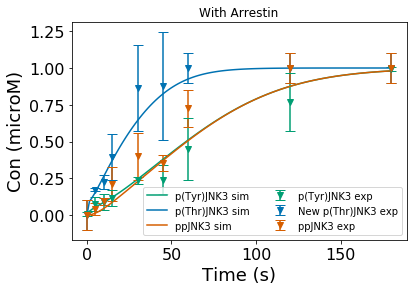

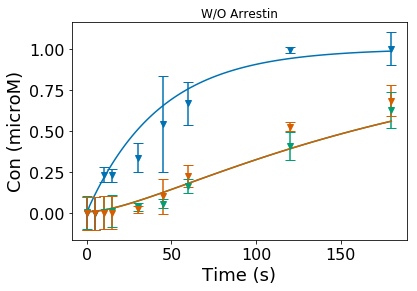

In [6]:
display_sim_data(fitted_pars)


# Plot all simulated trajectories

In [7]:
from tropical.visualize_trajectories import VisualizeTrajectories

In [9]:
vt_noarrestin = VisualizeTrajectories(model, 'simulations/simulations_noarrestin_scipy_181.h5', clusters=None)

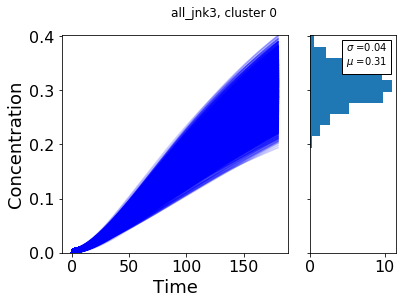

In [10]:
vt_noarrestin.plot_cluster_dynamics(species=['all_jnk3'], fig_name='no_arrestin_all_jnk3.png')

In [11]:
vt_arrestin = VisualizeTrajectories(model, 'simulations/simulations_arrestin_scipy_181.h5', clusters=None)

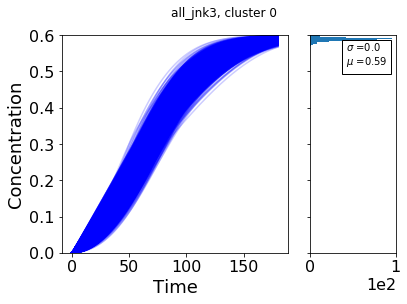

In [12]:
vt_arrestin.plot_cluster_dynamics(species=['all_jnk3'], fig_name='arrestin_all_jnk3.png')